<h1>Locating with Healthsites.io Notebook - Senegal<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-Geob-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-Geob-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to Geob Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-Geob-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-Geob-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to Geob Adm 2</a></span></li><li><span><a href="#Match-orgunitlevel2-to-Geob-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-Geob-Adm-1-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Match orgunitlevel2 to Geob Adm 1</a></span></li></ul></li></ul></li></ul></div>

Version: April 26, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os
from datetime import datetime
import geopandas as gpd
import pandas as pd
from geopy.geocoders import Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
from os.path import join
from dotenv import load_dotenv, find_dotenv

# local imports
import geocoding_utils as gcu
import preprocessing_utils as ppu
import search_utils as ssu

In [2]:
iso3 = "SEN"
diso = "sn"
country = "Senegal"
input_dir = "/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/data"
input_filename = "preprocess_SEN_matches.csv"
output_dir = join(input_dir, "output", iso3)
num_admin_levels = 3
num_org_levels = 5
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']
org_level_front_wtr = ["cs", "clinique",  "dispensaire", "dpc", "maternite", "maternité", "pm","mac","ps","privé ", "rm"]

In [3]:
master_table = pd.read_csv(os.path.join(input_dir, input_filename), encoding='utf-8')
geob_arr = ppu.get_geoboundaries(num_admin_levels, iso3)

In [4]:
# Senegal-specific update
master_table['orgunitlevel5'] = master_table['organisationunitname']

In [5]:
len(master_table)

1837

In [6]:
master_table.head(2)

,Unnamed: 0,index,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,orgunitlevel4_edit,adm3,orgunitlevel3_edit,adm2,orgunitlevel2_edit,orgunitlevel5
0,0,0,Sénégal,RM Louga,Kebemer,CS Gueoul,ABw3PNnM6MU,CS Gueoul,NaN,CS II,CS Gueoul,NaN,Kebemer,Kebemer,RM Louga,CS Gueoul
1,1,8,Sénégal,RM Matam,Matam,PS Danthiady,MdLYr6myUuV,PS Danthiady,NaN,NaN,PS Danthiady,NaN,Matam,Matam,RM Matam,PS Danthiady


In [7]:
for org_lvl in range(2, num_org_levels+1):
    print(f"Unique Level {org_lvl}: {len(master_table[f'orgunitlevel{org_lvl}'].unique())}")


Unique Level 2: 14
Unique Level 3: 79
Unique Level 4: 1779
Unique Level 5: 1779


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.

In QGIS, I created centroids from the ways then merged it with the points.
DLH Note: I didn't have access to this merge, so am using the nodes.shp only, for proof of concept

https://healthsites.io/map?country=Liberia

In [8]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", country, f"{country}-node.shp"))
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()
nodes_io['name'] = nodes_io['name'].str.lower()
nodes_io.loc[:, "is_point"] = nodes_io.apply(lambda x: type(x.geometry)==Point, axis=1)

In [9]:
len(nodes_io.loc[~nodes_io.is_point])

0

In [10]:
len(nodes_io.loc[nodes_io.geometry.is_valid])==len(nodes_io)

True

In [11]:
records = master_table.copy()
records['geocoding_method'] = "None"
records['NAME'] = records[f'orgunitlevel{num_org_levels}'].str.lower()
nodes_io = ppu.remove_words_df(nodes_io, 'name', words_to_remove)
records = ppu.remove_words_df(records, 'NAME', words_to_remove)
records = ppu.remove_from_front_df(records, 'NAME', words_to_remove=org_level_front_wtr)

In [12]:


for org_lev in range(4, num_org_levels+1):

    for idx, row in tqdm(records.iterrows()):

        # Check if there is another entry with location
        match, score = ssu.match_name(row.NAME, list(nodes_io['name']), 80)
    #     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)

        if score > 0:
            #print(row.NAME, match)
            matching_row = nodes_io.loc[nodes_io['name']==match].copy()
            res = matching_row.iloc[0]

            adm_idx = num_admin_levels
            for geobIdx in range(num_admin_levels-1, -1, -1): # reverse loop
                if f"adm{adm_idx}" in records.columns and not pd.isna(row[f"adm{adm_idx}"]):
                    geob = geob_arr[geobIdx]
                    adm = geob.loc[geob['shapeName'] == row[f'adm{adm_idx}']].copy()
                    if adm.contains(res.geometry).values[0] == True:
                        records.loc[idx, "longitude"] = res.geometry.x
                        records.loc[idx, "latitude"] = res.geometry.y
                        records.loc[idx, "geocoding_method"] = f"Location from Health Sites IO and within admin {adm_idx}"
                adm_idx -= 1


1736it [00:32, 53.48it/s]
1736it [00:33, 52.50it/s]


In [13]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,11,0.6%
None,1725,99.4%


# Geocoding with APIs

In [1]:
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [15]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [16]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset[f"adm{num_admin_levels}"].isna()].copy()

In [17]:
len(records_subset)

2

In [18]:
records_subset.head(2)

,Unnamed: 0,index,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,orgunitlevel4_edit,adm3,orgunitlevel3_edit,adm2,orgunitlevel2_edit,orgunitlevel5,geocoding_method,NAME,longitude,latitude
81,81,510,Sénégal,RM Fatick,Diakhao,Cs Diakhao,U7HoRcqOS1s,Cs Diakhao,NaN,NaN,Cs Diakhao,Diakhao,Diakhao,NaN,RM Fatick,Cs Diakhao,None,diakhao,NaN,NaN
1717,1717,72529,Sénégal,RM Saint-Louis,Richard Toll,CSS,GwqvpB5dAn7,CSS,NaN,NaN,CSS,Niaguis,Richard Toll,NaN,RM Saint-Louis,CSS,None,css,NaN,NaN


In [19]:
smallest_geob = geob_arr[-1]
print(len(smallest_geob))
for adm_idx in range(num_admin_levels-1, -1, -1): # reverse order
    admNum = adm_idx+1
    if adm_idx > 0 and f'adm{admNum}' in records_subset.columns:

        print(f"Facility name and admin {admNum} names")
        for idx, row in records_subset.iterrows():
            if  not pd.isna(row[f"adm{admNum}"]):
                adm = smallest_geob.loc[smallest_geob['shapeName'] == row[f'adm{admNum}']].copy()

                records = gcu.run_geocoding(idx, row, records, adm, ['NAME', f'adm{admNum}'], diso,
                                            geolocator_bing, geolocator_osm, geolocator_google)


            records_subset = records.loc[records.geocoding_method=="None"].copy()
            records_subset = records_subset.loc[~records_subset[f"adm{admNum}"].isna()].copy()
            if adm_idx -1 > 0  and f'adm{admNum-1}' in records_subset.columns:
                records_subset = records_subset.loc[~records_subset[f"adm{admNum-1}"].isna()].copy()
            print(f"Num not found: {len(records_subset)}")

121
Facility name and admin 3 names
Items: ['diakhao', 'Diakhao']
Num not found: 0
Items: ['css', 'Niaguis']
Num not found: 0
Facility name and admin 2 names


In [20]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,11,0.6%
NAME and adm3 query Bing,1,0.1%
NAME and adm3 query OSM,1,0.1%
None,1723,99.3%


## Orgunitlevel5 names

Geocode based on orgunitlevel 5 name.  
Check to make sure result falls within admin 3 polygon.  

In [21]:
records['NAME5'] = records['orgunitlevel5'].str.lower()
ppu.remove_words(records, 'NAME5', words_to_remove)

records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset[f"adm{num_admin_levels}"].isna()].copy()

In [22]:
admNum = num_admin_levels

for org_idx in range(num_org_levels, -1, -1): # reverse order
    if org_idx > 3:
        the_cols = ['NAME5', f'adm{admNum}'] if org_idx == 5 else ['NAME5', f'orgunitlevel{org_idx}']
        print(f"Geocoding for org level {org_idx}")
        orglev_df = records_subset[[f'orgunitlevel{org_idx}', 'NAME5', f'adm{admNum}', 'orgunitlevel1', 'geocoding_method']].drop_duplicates().copy()
        print(f"Num recs at org level {org_idx}: {len(orglev_df)}")
        print(f"Cols: {orglev_df.columns}")
        for idx, row in orglev_df.iterrows():

            adm = smallest_geob.loc[smallest_geob['shapeName'] == row[f'adm{admNum}']].copy()
            #print(len(adm))
            orglev_df = gcu.run_geocoding(idx, row, orglev_df, adm, the_cols, diso,
                              geolocator_bing, geolocator_osm, geolocator_google)
        print(orglev_df.geocoding_method.value_counts())

        for idx, row in tqdm(records_subset.iterrows()):
            if org_idx == num_org_levels:
                orglev_geocoded = orglev_df.loc[orglev_df['NAME5']==row['NAME5']].iloc[0]
                records.loc[idx, "longitude"] = orglev_geocoded.longitude
                records.loc[idx, "latitude"] = orglev_geocoded.latitude
                records.loc[idx, "geocoding_method"] = orglev_geocoded.geocoding_method
            else:
                if row.geocoding_method =="None":
                    cent = adm.geometry.representative_point().iloc[0]
                    records.loc[idx, "longitude"] = cent.x
                    records.loc[idx, "latitude"] = cent.y
                    records.loc[idx, "geocoding_method"] = "District centroid"

        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{admNum}"].isna()].copy()

Geocoding for org level 5
Num recs at org level 5: 0
Cols: Index(['orgunitlevel5', 'NAME5', 'adm3', 'orgunitlevel1', 'geocoding_method'], dtype='object')
Series([], Name: geocoding_method, dtype: int64)


0it [00:00, ?it/s]


Geocoding for org level 4
Num recs at org level 4: 0
Cols: Index(['orgunitlevel4', 'NAME5', 'adm3', 'orgunitlevel1', 'geocoding_method'], dtype='object')
Series([], Name: geocoding_method, dtype: int64)


0it [00:00, ?it/s]


In [23]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,11,0.6%
NAME and adm3 query Bing,1,0.1%
NAME and adm3 query OSM,1,0.1%
None,1723,99.3%


## Admin 3  and admin 2 names

In [24]:
admin_lev = 2
for geob_idx in range(len(geob_arr)-1, -1, -1): # reverse order
    print(f"Geoboundary idx: {geob_idx}")
    geob = geob_arr[geob_idx]
    if f"adm{admin_lev}" in records_subset.columns:
        records_subset = records.loc[records.geocoding_method=="None"].copy()
        records_subset = records_subset.loc[~records_subset[f"adm{admin_lev}"].isna()].copy()
        print(f"Length of recs to check: {len(records_subset)}")

        orglev4_df = records_subset[['orgunitlevel4', f"adm{admin_lev}", 'orgunitlevel1']].drop_duplicates().copy()
        len(orglev4_df)

        for idx, row in tqdm(orglev4_df.iterrows()):
            adm = geob.loc[geob['shapeName'] == row[f"adm{admin_lev}"]].copy()
            orglev4_df = gcu.run_geocoding(idx, row, orglev4_df, adm, ['orgunitlevel4', f"adm{admin_lev}"], diso,
                                           geolocator_bing, geolocator_osm, geolocator_google)

        for idx, row in tqdm(records_subset.iterrows()):
            orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]
            records.loc[idx, "longitude"] = orglev4_geocoded.longitude
            records.loc[idx, "latitude"] = orglev4_geocoded.latitude
            records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

        admin_lev -= 1

Geoboundary idx: 2
Length of recs to check: 1213


0it [00:00, ?it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Gueoul', 'Kebemer']


1it [00:00,  3.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Danthiady', 'Matam']


2it [00:00,  2.32it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Mbapp', 'Ranerou']


3it [00:01,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dinguiraye', 'Ranerou']


4it [00:01,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Falifa', 'Ranerou']


5it [00:02,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mme Elisabeth Diouf', 'Diourbel']


6it [00:02,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndondol', 'Bambey']


7it [00:03,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngodiba', 'Kaffrine']


8it [00:03,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sibassor', 'Kaolack']


9it [00:04,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['A SEYNABOU FALL', 'Pikine']


10it [00:04,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['AMA (Agence des Musulmans d’Afrique)', 'Sedhiou']


11it [00:05,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['ASBEF', 'Louga']


12it [00:05,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Adja Khady Thom', 'Kaolack']


13it [00:06,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Baba Top', 'Kaolack']


14it [00:06,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Binetou Rassoul', 'Kaolack']


15it [00:07,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Pape Omar Diouf', 'Kaolack']


16it [00:07,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Yacine Dieye', 'Kaolack']


17it [00:08,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Yaye Amy', 'Kaolack']


18it [00:08,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet paramédical sokhna Néné Bâ', 'Diourbel']


19it [00:09,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Cabinet Privé Bamtare', 'Guediawaye']


20it [00:09,  2.04it/s]

Items: ['Cabinet Privé Communautaire AcDev', 'Guediawaye']


21it [00:10,  2.02it/s]

Items: ['Cabinet Privé Communautaire Golf Sud', 'Guediawaye']


22it [00:10,  1.96it/s]

Items: ['Cabinet Privée Ma Salam', 'Guediawaye']


23it [00:11,  1.96it/s]

Items: ['Caisse de Securite Sociale', 'Guediawaye']


24it [00:11,  2.05it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre Medical SOS', 'Kaolack']


25it [00:12,  1.63it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre Medico-Social Ben Anas', 'Kaolack']


26it [00:13,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Bodian', 'Kaolack']


27it [00:13,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Diarama', 'Kaolack']


28it [00:14,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Jaboot Mu Selami Dr Boucal', 'Kaolack']


29it [00:14,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique K Ababacar Sy', 'Tivaoune']


30it [00:14,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Lampe Fall', 'Kaolack']


31it [00:15,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Lansar Pikine', 'Pikine']


32it [00:15,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Ndiaye', 'Saint Louis']


33it [00:16,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Clinique Privé Thieno Kandji', 'Guediawaye']


34it [00:16,  2.03it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Sarr', 'Tivaoune']


35it [00:17,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique shiffah', 'Kaolack']


36it [00:18,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Croix Rouge', 'Diourbel']


37it [00:18,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Croix Rouge HLM Paris', 'Guediawaye']


38it [00:19,  1.92it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS 10ème de THIES', 'Thies']


39it [00:19,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Bakel', 'Bakel']


40it [00:20,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS BALA', 'Goudiry']


41it [00:20,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Bambaly', 'Sedhiou']


42it [00:20,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Bambey', 'Bambey']


43it [00:21,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Bignona', 'Bignona']


44it [00:22,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Bounkiling', 'Bounkiling']


45it [00:22,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Dagana', 'Dagana']


46it [00:23,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Dahra', 'Dakar']


47it [00:23,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS de Kaffrine', 'Kaffrine']


48it [00:24,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS de Mbirkilane', 'Birkelane']


49it [00:24,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Diamniadio', 'Tambacounda']


50it [00:25,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Diourbel', 'Diourbel']


51it [00:25,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Dominique', 'Pikine']


52it [00:26,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Fatick', 'Fatick']


53it [00:26,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Foundiougne', 'Foundiougne']


54it [00:27,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Galoya', 'Podor']


55it [00:27,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Gossas', 'Gossas']


56it [00:28,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Goudiry', 'Goudiry']


57it [00:28,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Goudomp', 'Goudomp']


58it [00:29,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Guinguineo', 'Guinguineo']


59it [00:29,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Hamady Ounare', 'Kanel']


60it [00:30,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Kanel', 'Kanel']


61it [00:30,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Kasnack', 'Kaolack']


62it [00:31,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Kebemer', 'Kebemer']


63it [00:31,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Kedougou', 'Kedougou']


64it [00:32,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Khadim Rassoul', 'Mbour']


65it [00:32,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Kolda', 'Kolda']


66it [00:33,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Koumpentoum', 'Koumpentoum']


67it [00:33,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Koungheul', 'Koungheul']


68it [00:33,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Linguere', 'Linguere']


69it [00:34,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Louga', 'Louga']


70it [00:34,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Malem Hodar', 'Malem Hodar']


71it [00:35,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Matam', 'Matam']


72it [00:36,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Mbacke', 'Mbacke']


73it [00:36,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Mbour', 'Mbour']


74it [00:36,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['CS Medina gounass', 'Velingara']


75it [00:37,  1.71it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Medina Yoro Foulah', 'Medina Yoroufoula']


76it [00:38,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Mpal', 'Saint Louis']


77it [00:38,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Ndindy', 'Diourbel']


78it [00:39,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Ndoffane', 'Tivaoune']


79it [00:39,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Niodior', 'Foundiougne']


80it [00:40,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Nioro', 'Ranerou']


81it [00:40,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Oussouye', 'Oussouye']


82it [00:41,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Pete', 'Podor']


83it [00:41,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Podor', 'Podor']


84it [00:42,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Polyclinique', 'Rufisque']


85it [00:42,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Ranerou', 'Ranerou']


86it [00:43,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Sagne Bambara', 'Kaolack']


87it [00:43,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Saint - Louis', 'Saint Louis']


88it [00:44,  1.61it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Salemata', 'Salemata']


89it [00:44,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Samine', 'Goudomp']


90it [00:45,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Saraya', 'Saraya']


91it [00:45,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Sedhiou', 'Sedhiou']


92it [00:46,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Tambacounda', 'Tambacounda']


93it [00:46,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Thile Boubacar', 'Podor']


94it [00:47,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Tivaouane', 'Tivaoune']


95it [00:47,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['CS Velingara', 'Velingara']


96it [00:48,  1.86it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Wack Ngouna', 'Ranerou']


97it [00:48,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['CS Wakhinane', 'Guediawaye']


98it [00:49,  1.78it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Waounde', 'Kanel']


99it [00:49,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Ziguinchor', 'Ziguinchor']


100it [00:50,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire Prive Yeurmande', 'Gossas']


101it [00:50,  2.16it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Ballandine', 'Bignona']


102it [00:51,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Brin', 'Ziguinchor']


103it [00:51,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC de Koumbidia', 'Koungheul']


104it [00:52,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC de Ngohe Plus Maternite', 'Diourbel']


105it [00:52,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Diohine Notre Dame du Sacre Coeur', 'Fatick']


106it [00:53,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Diourbel Tock', 'Diourbel']


107it [00:53,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Lyndiane St Joseph', 'Ziguinchor']


108it [00:54,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Maka Kahone', 'Guinguineo']


109it [00:54,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Mangaroungou', 'Goudomp']


110it [00:55,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Mater carmeli', 'Tivaoune']


111it [00:55,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Missira', 'Koungheul']


112it [00:56,  1.82it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Mlomp', 'Oussouye']


113it [00:56,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Saint Martin de Bambey', 'Bambey']


114it [00:57,  1.79it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Simbandi Balante', 'Goudomp']


115it [00:57,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Soutou', 'Bignona']


116it [00:58,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Thingue', 'Gossas']


117it [00:58,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS 2 Thierno Birahim Ndao', 'Kaffrine']


118it [00:59,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['EPS 3 Dalal Jamm', 'Guediawaye']


119it [00:59,  2.05it/s]

Items: ['EPS1  Roi Baudoin', 'Guediawaye']


120it [01:00,  1.97it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS1 ABDOU AZIZ SY', 'Tivaoune']


121it [01:00,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS1 Linguere', 'Linguere']


122it [01:01,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS1 Mbour', 'Mbour']


123it [01:01,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS1 Youssou Mbargane Diop', 'Rufisque']


124it [01:02,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2  de Ouroussogui', 'Matam']


125it [01:02,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2  Kolda', 'Kolda']


126it [01:03,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2  Régional de Matam', 'Matam']


127it [01:03,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Amadou S Dieuguene', 'Thies']


128it [01:04,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Amadou Sakhir Mbaye de Louga', 'Louga']


129it [01:04,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Barthimée Confessionel', 'Thies']


130it [01:05,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 CHR ZIGUINCHOR', 'Ziguinchor']


131it [01:05,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 de NDioum', 'Podor']


132it [01:06,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 El hadji Ibrahima NIASS de Kaolack', 'Kaolack']


133it [01:06,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Hopital de la Paix', 'Ziguinchor']


134it [01:07,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Lubke de Diourbel', 'Diourbel']


135it [01:07,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Saint Jean de Dieu de Thiès', 'Thies']


136it [01:08,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Sedhiou', 'Sedhiou']


137it [01:08,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS2 Tambacounda', 'Tambacounda']


138it [01:09,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS3 Pikine', 'Mbour']


139it [01:09,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['I.P.S', 'Pikine']


140it [01:13,  1.44s/it]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['IMEK', 'Kaolack']


141it [01:13,  1.14s/it]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['IMEK 2', 'Guinguineo']


142it [01:14,  1.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Maternite Bargny', 'Tambacounda']


143it [01:14,  1.20it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Maternite Elisabeth', 'Guediawaye']


144it [01:15,  1.32it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Maternite Sebikotane', 'Tambacounda']


145it [01:15,  1.57it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Maternité Pire', 'Tivaoune']


146it [01:16,  1.64it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['P.S. Municipal Iv', 'Guediawaye']


147it [01:17,  1.44it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PMI Goutte de Lait', 'Thies']


148it [01:17,  1.62it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Pmi Sor', 'Saint Louis']


149it [01:18,  1.66it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Poste Croix Rouge', 'Velingara']


150it [01:18,  1.81it/s]

Items: ['Privé Médicos AR', 'Guediawaye']


151it [01:19,  2.07it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Abattoirs', 'Kaolack']


152it [01:19,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Adeane', 'Ziguinchor']


153it [01:20,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Aere Lao', 'Podor']


154it [01:20,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Affe', 'Dakar']


155it [01:21,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Afia', 'Tambacounda']


156it [01:21,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Agnack', 'Ziguinchor']


157it [01:22,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Aguiyaye', 'Bambey']


158it [01:22,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ainoumady', 'Goudiry']


159it [01:23,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Alwar', 'Podor']


160it [01:23,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Anambe', 'Kolda']


161it [01:24,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Aoure', 'Kanel']


162it [01:24,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Arafat', 'Rufisque']


163it [01:25,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Aroundou', 'Bakel']


164it [01:25,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Athiou', 'Guinguineo']


165it [01:26,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Baba Garage', 'Bambey']


166it [01:26,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Back Samba Dior', 'Guinguineo']


167it [01:27,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bacoboeuf', 'Fatick']


168it [01:27,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Badagore', 'Ranerou']


169it [01:28,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Badion', 'Medina Yoroufoula']


170it [01:28,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Badioncoto', 'Bignona']


171it [01:29,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Badioure', 'Bignona']


172it [01:29,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bagadadji', 'Kolda']


173it [01:30,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Baghagha', 'Ziguinchor']


174it [01:30,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Baghere', 'Goudomp']


175it [01:31,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Baila', 'Bignona']


176it [01:31,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ballou', 'Bakel']


177it [01:32,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bamba Thialene', 'Koumpentoum']


178it [01:32,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bambadinka', 'Kolda']


179it [01:33,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bambadji', 'Saraya']


180it [01:33,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bambay Serere', 'Bambey']


181it [01:34,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bambeye Serere 2', 'Bambey']


182it [01:34,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Banda Fassi', 'Kedougou']


183it [01:35,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bandegne', 'Kebemer']


184it [01:35,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bango', 'Saint Louis']


185it [01:36,  1.74it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bantako', 'Kedougou']


186it [01:36,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Barkedji', 'Linguere']


187it [01:37,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Barobe Wassatake', 'Podor']


188it [01:37,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bassar', 'Foundiougne']


189it [01:38,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bassoul', 'Foundiougne']


190it [01:38,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Batal', 'Bambey']


191it [01:39,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Belel Kelle', 'Podor']


192it [01:39,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Belfort', 'Ziguinchor']


193it [01:40,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bembou', 'Saraya']


194it [01:40,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bemet Bidjini', 'Sedhiou']


195it [01:41,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bicole', 'Fatick']


196it [01:41,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bidiam', 'Birkelane']


197it [01:42,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Binako', 'Goudomp']


198it [01:42,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bira', 'Tambacounda']


199it [01:43,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bode lao', 'Podor']


200it [01:43,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bogal', 'Bounkiling']


201it [01:44,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boguel', 'Podor']


202it [01:44,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bohe Baledji', 'Tambacounda']


203it [01:45,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boinadji', 'Matam']


204it [01:45,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boke Dialoube', 'Podor']


205it [01:46,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boke Mbaybe Salsalbe', 'Podor']


206it [01:46,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bokhol', 'Dagana']


207it [01:47,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boki Sarankobe', 'Podor']


208it [01:47,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bokidiawe', 'Matam']


209it [01:48,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bokidiawe 2', 'Matam']


210it [01:48,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bokiladji', 'Kanel']


211it [01:49,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bokissaboudou', 'Kanel']


212it [01:49,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bona', 'Bounkiling']


213it [01:50,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Bonconto', 'Velingara']


214it [01:50,  1.86it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bossolel', 'Birkelane']


215it [01:51,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Botou', 'Tambacounda']


216it [01:51,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boucotte', 'Oussouye']


217it [01:52,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boudhié Samine', 'Sedhiou']


218it [01:52,  2.16it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boudouk', 'Bounkiling']


219it [01:53,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bougoutoub', 'Bignona']


220it [01:53,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boulal Nianghene', 'Dakar']


221it [01:54,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boulel', 'Kaffrine']


222it [01:54,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boumouda', 'Sedhiou']


223it [01:55,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bouna Kane', 'Kolda']


224it [01:55,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bouno', 'Sedhiou']


225it [01:56,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boureck', 'Bignona']


226it [01:56,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bourofaye', 'Ziguinchor']


227it [01:57,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bourouko', 'Medina Yoroufoula']


228it [01:57,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boustane', 'Kaolack']


229it [01:58,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bouteyni', 'Dagana']


230it [01:58,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boutoupa', 'Ziguinchor']


231it [01:59,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bow', 'Kanel']


232it [01:59,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cabrousse', 'Oussouye']


233it [02:00,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cadjinolle', 'Oussouye']


234it [02:00,  2.16it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cagnoute', 'Oussouye']


235it [02:01,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cap Skirring', 'Oussouye']


236it [02:01,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS CAPEC', 'Mbour']


237it [02:02,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Carabane Ile', 'Oussouye']


238it [02:02,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Carounate', 'Oussouye']


239it [02:03,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cascas', 'Podor']


240it [02:03,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Chaden', 'Mbour']


241it [02:04,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cheikh Anta', 'Diourbel']


242it [02:04,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cherif Lo', 'Tivaoune']


243it [02:05,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cite Lamy', 'Thies']


244it [02:05,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Cite Niakh', 'Thies']


245it [02:06,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Colette Senghor', 'Ziguinchor']


246it [02:06,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Colobane Lambaye', 'Guinguineo']


247it [02:07,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Communal', 'Dakar']


248it [02:07,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Commune de Podor', 'Podor']


249it [02:08,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Coubalan', 'Bignona']


250it [02:08,  1.78it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Coubanao', 'Bignona']


251it [02:09,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Coumbacara', 'Kolda']


252it [02:09,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Coura Mouride', 'Koungheul']


253it [02:10,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dabaly', 'Ranerou']


254it [02:10,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dabo', 'Kolda']


255it [02:11,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Daga Youndoume', 'Tivaoune']


256it [02:11,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dakately', 'Salemata']


257it [02:12,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dalifort', 'Pikine']


258it [02:12,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dalla Ngabou', 'Mbacke']


259it [02:13,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Daloto', 'Saraya']


260it [02:13,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dangou', 'Rufisque']


261it [02:14,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dankh Sene', 'Diourbel']


262it [02:14,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dar Salam Fodé', 'Tambacounda']


263it [02:15,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dara Halaybe', 'Podor']


264it [02:15,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dara Mboss', 'Guinguineo']


265it [02:16,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Alpha', 'Tivaoune']


266it [02:16,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Kaffat', 'Koungheul']


267it [02:17,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Khoudoss', 'Pikine']


268it [02:17,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Mbiteyene', 'Tivaoune']


269it [02:18,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Nahim', 'Mbacke']


270it [02:18,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Pakathiar', 'Tivaoune']


271it [02:19,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Ridouane', 'Kaolack']


272it [02:19,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam', 'Mbour']


273it [02:20,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam 2', 'Koumpentoum']


274it [02:20,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam Commune', 'Ranerou']


275it [02:21,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam DIOP', 'Linguere']


276it [02:21,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam Mouride', 'Ranerou']


277it [02:22,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam Nioro', 'Ranerou']


278it [02:22,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam Urbain', 'Fatick']


279it [02:23,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Daroukhane', 'Guediawaye']


280it [02:23,  1.92it/s]

Items: ['PS Darourakhmane', 'Guediawaye']


281it [02:24,  2.03it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dawady', 'Tambacounda']


282it [02:24,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS de Dalaba', 'Kedougou']


283it [02:25,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dealy', 'Dakar']


284it [02:25,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Deggo', 'Pikine']


285it [02:26,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dembacani', 'Kanel']


286it [02:26,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dembo Coly', 'Sedhiou']


287it [02:27,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Demet', 'Podor']


288it [02:27,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dendeye Gouyegui', 'Mbacke']


289it [02:28,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diaba', 'Podor']


290it [02:28,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diabel', 'Gossas']


291it [02:29,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diacksao', 'Mbour']


292it [02:29,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diacounda Diolene', 'Bounkiling']


293it [02:30,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diacoye Banga', 'Bignona']


294it [02:30,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diaga Keur Serigne', 'Malem Hodar']


295it [02:31,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS DIagali', 'Linguere']


296it [02:31,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diagle', 'Dagana']


297it [02:32,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diagnon', 'Ziguinchor']


298it [02:32,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diagnoum', 'Podor']


299it [02:33,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diakene Diola', 'Oussouye']


300it [02:33,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diakene Ouolof', 'Oussouye']


301it [02:34,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diakha Macky', 'Saraya']


302it [02:34,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diakha Madina', 'Saraya']


303it [02:35,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diakhaba', 'Saraya']


304it [02:35,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diakhaling', 'Saraya']


305it [02:36,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dialacoumbi', 'Kolda']


306it [02:36,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Dialadiang', 'Velingara']


307it [02:37,  1.93it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dialegne', 'Kaolack']


308it [02:37,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dialembere', 'Kolda']


309it [02:38,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dialloubé', 'Kanel']


310it [02:38,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dialocoto', 'Tambacounda']


311it [02:39,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dialocounda', 'Bounkiling']


312it [02:39,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diam Diam', 'Koumpentoum']


313it [02:40,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamagadio', 'Kaffrine']


314it [02:40,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamaguene', 'Mbacke']


315it [02:41,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamagueune', 'Ranerou']


316it [02:41,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamal', 'Podor']


317it [02:42,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamaye', 'Bignona']


318it [02:42,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diambati', 'Bounkiling']


319it [02:43,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diambo', 'Podor']


320it [02:43,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamegueune', 'Mbour']


321it [02:44,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diamel', 'Matam']


322it [02:44,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diana Malary', 'Sedhiou']


323it [02:45,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diandioly', 'Matam']


324it [02:45,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dianke Souf', 'Malem Hodar']


325it [02:46,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diannah Bah', 'Sedhiou']


326it [02:46,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Diaobe', 'Velingara']


327it [02:47,  1.83it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diare Mbolo', 'Goudiry']


328it [02:47,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diareng', 'Goudomp']


329it [02:48,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diarere', 'Fatick']


330it [02:48,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diaroume', 'Bounkiling']


331it [02:49,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diattacounda', 'Goudomp']


332it [02:49,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diattar', 'Podor']


333it [02:50,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diawara', 'Bakel']


334it [02:50,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dielerlou Syll', 'Louga']


335it [02:51,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diella', 'Kanel']


336it [02:51,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diembering', 'Oussouye']


337it [02:52,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diende', 'Sedhiou']


338it [02:52,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diendieme', 'Bounkiling']


339it [02:53,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Digane', 'Mbacke']


340it [02:53,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dimat', 'Podor']


341it [02:54,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dimboli', 'Kedougou']


342it [02:54,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dimiskha', 'Koungheul']


343it [02:55,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dinde Felo', 'Kedougou']


344it [02:55,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diocadou', 'Bignona']


345it [02:56,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diogane', 'Foundiougne']


346it [02:56,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diogo', 'Tivaoune']


347it [02:57,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diohine', 'Fatick']


348it [02:57,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diokoul', 'Kebemer']


349it [02:58,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diokoul Kher', 'Rufisque']


350it [02:58,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diokoul Mbellboul', 'Kaffrine']


351it [02:59,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diokoul Wague', 'Rufisque']


352it [02:59,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diondji', 'Bignona']


353it [03:00,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dionewar', 'Foundiougne']


354it [03:00,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diongui', 'Podor']


355it [03:01,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diorga', 'Rufisque']


356it [03:01,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dioude Diabe', 'Podor']


357it [03:02,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dioulacolon', 'Kolda']


358it [03:02,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dioulanghel Banta', 'Medina Yoroufoula']


359it [03:03,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dioumada', 'Kaffrine']


360it [03:03,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diouroup', 'Fatick']


361it [03:04,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djibabouya', 'Sedhiou']


362it [03:04,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djibanar', 'Goudomp']


363it [03:05,  1.66it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djibidione', 'Bignona']


364it [03:06,  1.76it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djibock', 'Ziguinchor']


365it [03:06,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djifanghor', 'Ziguinchor']


366it [03:06,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djilakh', 'Mbour']


367it [03:07,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djilekhar', 'Tivaoune']


368it [03:07,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djilonguia', 'Bignona']


369it [03:08,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djinani', 'Bounkiling']


370it [03:08,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djinkore', 'Tambacounda']


371it [03:09,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djiragone', 'Bounkiling']


372it [03:09,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djiredji', 'Sedhiou']


373it [03:10,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djirnda', 'Foundiougne']


374it [03:10,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Djouth Nguel', 'Kaffrine']


375it [03:11,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dodel', 'Podor']


376it [03:11,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dodji', 'Linguere']


377it [03:12,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dolly', 'Linguere']


378it [03:12,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Donaye/ Taredji', 'Podor']


379it [03:13,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dondou', 'Matam']


380it [03:13,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Doubirou', 'Velingara']


381it [03:14,  1.84it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dougar', 'Tambacounda']


382it [03:14,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Doumga Lao', 'Podor']


383it [03:15,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Doumga Ouro Alpha', 'Matam']


384it [03:15,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dounde', 'Kanel']


385it [03:16,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dounguel', 'Podor']


386it [03:16,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Doué', 'Podor']


387it [03:17,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Doyoly', 'Mbacke']


388it [03:17,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dya', 'Kaolack']


389it [03:18,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Elinkine', 'Oussouye']


390it [03:18,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Emetteur', 'Fatick']


391it [03:19,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Enampor', 'Ziguinchor']


392it [03:19,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ethiolo', 'Salemata']


393it [03:20,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fadiara', 'Kanel']


394it [03:20,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fadiga', 'Kedougou']


395it [03:21,  2.16it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fafacourou', 'Medina Yoroufoula']


396it [03:21,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fallokh  Malicounda', 'Mbour']


397it [03:22,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fanaye', 'Podor']


398it [03:22,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fandane', 'Mbour']


399it [03:23,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Faoune', 'Bounkiling']


400it [03:23,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Farabougou', 'Guinguineo']


401it [03:24,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass', 'Guinguineo']


402it [03:24,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass Boye', 'Tivaoune']


403it [03:25,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass Gounass', 'Koumpentoum']


404it [03:25,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass HLM', 'Ranerou']


405it [03:26,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass Mbao', 'Mbour']


406it [03:26,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass NGOM', 'Saint Louis']


407it [03:27,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass Thieckene', 'Koungheul']


408it [03:27,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fass Thioffack', 'Kaolack']


409it [03:28,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fayil', 'Fatick']


410it [03:28,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Fith Mith', 'Guediawaye']


411it [03:29,  2.05it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fongolimby', 'Kedougou']


412it [03:29,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fouloum', 'Tivaoune']


413it [03:30,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Foumi Hara', 'Kanel']


414it [03:30,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fourdou', 'Ranerou']


415it [03:31,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Fété Niébé', 'Matam']


416it [03:31,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gabou', 'Bakel']


417it [03:32,  1.76it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gadapara', 'Kolda']


418it [03:32,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gade Escale', 'Diourbel']


419it [03:33,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gadiack', 'Fatick']


420it [03:33,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gae', 'Dagana']


421it [03:34,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gagnick', 'Guinguineo']


422it [03:35,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gaina Mbar', 'Gossas']


423it [03:35,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gainth Pathe', 'Koungheul']


424it [03:36,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gainthes Kayes', 'Ranerou']


425it [03:36,  2.18it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gallade', 'Bakel']


426it [03:36,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gamadji Sarre', 'Podor']


427it [03:37,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gandiaye', 'Kaolack']


428it [03:37,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gandigal', 'Mbour']


429it [03:38,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gandon', 'Saint Louis']


430it [03:39,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ganguel Maka', 'Kanel']


431it [03:39,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ganguel Souley', 'Kanel']


432it [03:39,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gaode Boffe', 'Kanel']


433it [03:40,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gaol', 'Matam']


434it [03:40,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gassane Ndiawene', 'Linguere']


435it [03:41,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gatte', 'Bambey']


436it [03:41,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gawane', 'Bambey']


437it [03:42,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gniby', 'Kaffrine']


438it [03:42,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gognedji', 'Goudiry']


439it [03:43,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gollere', 'Podor']


440it [03:44,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Golmy', 'Bakel']


441it [03:44,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Goulokoum', 'Kaffrine']


442it [03:44,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gouloumbou', 'Tambacounda']


443it [03:45,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Goumal', 'Kanel']


444it [03:45,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Goumbayel', 'Goudiry']


445it [03:46,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gourel Djiadji', 'Tambacounda']


446it [03:46,  2.16it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gourgourène', 'Bambey']


447it [03:47,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gouriki Koliabé', 'Kanel']


448it [03:47,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gouye', 'Tambacounda']


449it [03:48,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Gouye Mouride', 'Rufisque']


450it [03:48,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Goxu Mbath', 'Saint Louis']


451it [03:49,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Grand Diourbel', 'Diourbel']


452it [03:49,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Grand Mbao', 'Mbour']


453it [03:50,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Grand Mbour', 'Mbour']


454it [03:50,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Grand Thies', 'Thies']


455it [03:51,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guede Chantier', 'Podor']


456it [03:51,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guede Village', 'Podor']


457it [03:52,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guerle', 'Mbacke']


458it [03:52,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guet Ndar', 'Saint Louis']


459it [03:53,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guidakhar', 'Dagana']


460it [03:53,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guinaw Rail Nord', 'Pikine']


461it [03:54,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guinaw Rail Sud', 'Pikine']


462it [03:54,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guire Yoro Bocar', 'Kolda']


463it [03:55,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Guiya', 'Podor']


464it [03:55,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Hadabere', 'Kanel']


465it [03:56,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Hamo Tefess', 'Guediawaye']


466it [03:56,  2.09it/s]

Items: ['PS Hamo V', 'Guediawaye']


467it [03:57,  1.98it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Hanene', 'Thies']


468it [03:57,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Henri Dunant(Croix Rouge)', 'Ziguinchor']


469it [03:58,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Hersent', 'Thies']


470it [03:58,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS HLM Las Palmas', 'Guediawaye']


471it [03:59,  2.05it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Hodar', 'Malem Hodar']


472it [03:59,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Hore', 'Kaffrine']


473it [04:00,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ibrahima Nima', 'Kolda']


474it [04:00,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ida Mouride', 'Koungheul']


475it [04:01,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Inor Diola', 'Bounkiling']


476it [04:01,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ka Fall', 'Tivaoune']


477it [04:02,  1.76it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kab Gaye', 'Kebemer']


478it [04:02,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kabacoto', 'Ranerou']


479it [04:03,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kabatoki', 'Kaolack']


480it [04:03,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Kabendou', 'Velingara']


481it [04:05,  1.16it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kadji', 'Linguere']


482it [04:06,  1.43it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kael', 'Mbacke']


483it [04:06,  1.61it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kaffrine II', 'Kaffrine']


484it [04:06,  1.68it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kagnarou', 'Bignona']


485it [04:07,  1.72it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kagnoube', 'Goudiry']


486it [04:07,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kaguitte', 'Ziguinchor']


487it [04:08,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kahene', 'Koumpentoum']


488it [04:08,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kahi', 'Kaffrine']


489it [04:09,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kahone', 'Kaolack']


490it [04:10,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Kalifourou', 'Velingara']


491it [04:10,  1.80it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kamb', 'Dakar']


492it [04:10,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kande 1', 'Ziguinchor']


493it [04:11,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kande II', 'Ziguinchor']


494it [04:11,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Kandia', 'Velingara']


495it [04:12,  1.90it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kandialang I', 'Ziguinchor']


496it [04:12,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kandialang II', 'Ziguinchor']


497it [04:13,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Kandiaye', 'Velingara']


498it [04:14,  1.84it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kanene', 'Kebemer']


499it [04:14,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kanouma', 'Koumpentoum']


500it [04:14,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Kaouné', 'Velingara']


501it [04:15,  1.91it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Karantaba', 'Goudomp']


502it [04:15,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Katane', 'Ranerou']


503it [04:16,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kathiote', 'Kaffrine']


504it [04:16,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kawour', 'Goudomp']


505it [04:17,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kawsara', 'Thies']


506it [04:17,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kaymor', 'Ranerou']


507it [04:18,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kelle Gueye', 'Louga']


508it [04:19,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kerewane', 'Medina Yoroufoula']


509it [04:19,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Abibou Niasse', 'Ranerou']


510it [04:19,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Ale Samba', 'Ranerou']


511it [04:20,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Aly Bassine', 'Tivaoune']


512it [04:20,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Amadou Yalla', 'Kebemer']


513it [04:21,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Ayip', 'Ranerou']


514it [04:21,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Babou', 'Kaffrine']


515it [04:22,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Baka', 'Tivaoune']


516it [04:23,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Birane Ndoupy', 'Ranerou']


517it [04:23,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Cheikh Oumar TOURE', 'Ranerou']


518it [04:23,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Issa', 'Thies']


519it [04:24,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Lahine Sakho', 'Ranerou']


520it [04:24,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Lassana', 'Tivaoune']


521it [04:25,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Maba Diakhou', 'Ranerou']


522it [04:26,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Madiabel 1', 'Ranerou']


523it [04:26,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Madiabel 2', 'Ranerou']


524it [04:27,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Madiop', 'Bambey']


525it [04:27,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Malick Marame', 'Koungheul']


526it [04:28,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Mandongo', 'Ranerou']


527it [04:28,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Mandoumbe', 'Koungheul']


528it [04:28,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Mbagne Diop', 'Kaolack']


529it [04:29,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Mbir Ndao', 'Tivaoune']


530it [04:30,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Mbouki', 'Birkelane']


531it [04:30,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Moussa', 'Ranerou']


532it [04:31,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Ndiaye', 'Louga']


533it [04:31,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Ngalgou', 'Diourbel']


534it [04:32,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Ngana', 'Diourbel']


535it [04:32,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Pathè', 'Birkelane']


536it [04:32,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Sader', 'Birkelane']


537it [04:33,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Saib Ndoye', 'Thies']


538it [04:34,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Samba Kane', 'Bambey']


539it [04:34,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Sawely', 'Birkelane']


540it [04:34,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Serigne Ablaye', 'Thies']


541it [04:35,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Serigne Bassirou', 'Tivaoune']


542it [04:35,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Serigne Louga Est', 'Louga']


543it [04:36,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Serigne Louga Ouest', 'Louga']


544it [04:36,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Serigne Mbaye Sarr', 'Diourbel']


545it [04:37,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Soce', 'Tivaoune']


546it [04:37,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Sountou', 'Ranerou']


547it [04:38,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keur Tapha', 'Ranerou']


548it [04:38,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kevoye', 'Salemata']


549it [04:39,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kharakhena', 'Saraya']


550it [04:39,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Khaîra Diaga', 'Malem Hodar']


551it [04:40,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Khor', 'Saint Louis']


552it [04:41,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Khossanto', 'Saraya']


553it [04:41,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Khourounar', 'Pikine']


554it [04:41,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kip Carrieres', 'Tambacounda']


555it [04:42,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kissane', 'Thies']


556it [04:43,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koar', 'Goudiry']


557it [04:43,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kohel', 'Ranerou']


558it [04:44,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kolibantang', 'Goudomp']


559it [04:44,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kongoly', 'Guinguineo']


560it [04:44,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kossanké', 'Kolda']


561it [04:45,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kothiary', 'Goudiry']


562it [04:46,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kougnara', 'Goudomp']


563it [04:46,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koukoto Simong', 'Koungheul']


564it [04:46,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koulinto', 'Medina Yoroufoula']


565it [04:47,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koulor', 'Goudiry']


566it [04:48,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koumbal', 'Tivaoune']


567it [04:48,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koumpal', 'Birkelane']


568it [04:48,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koundam', 'Kaolack']


569it [04:49,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koung Koung', 'Koungheul']


570it [04:49,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kounghany', 'Bakel']


571it [04:50,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Kounkane', 'Velingara']


572it [04:51,  1.72it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kourdane', 'Koungheul']


573it [04:51,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koussanar', 'Tambacounda']


574it [04:52,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koussy', 'Sedhiou']


575it [04:52,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Koutal', 'Tivaoune']


576it [04:53,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kouthia', 'Goudiry']


577it [04:53,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kouthia Gaidy', 'Koumpentoum']


578it [04:54,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kouthiaba', 'Koumpentoum']


579it [04:54,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Kélimane', 'Kaffrine']


580it [04:55,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS la Rochette', 'Mbour']


581it [04:55,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Labgar', 'Linguere']


582it [04:56,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lagnar', 'Diourbel']


583it [04:56,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lamarame', 'Tivaoune']


584it [04:57,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lambaye', 'Bambey']


585it [04:57,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Latmingue', 'Tivaoune']


586it [04:58,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Leona', 'Kaolack']


587it [04:58,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Linkering', 'Velingara']


588it [04:59,  1.67it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Linkédiang', 'Medina Yoroufoula']


589it [04:59,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lobaly', 'Kanel']


590it [05:00,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Loffé', 'Koumpentoum']


591it [05:00,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lohène', 'Ranerou']


592it [05:01,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lompoul', 'Kebemer']


593it [05:01,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Loro', 'Kebemer']


594it [05:02,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Louboudou Doué', 'Podor']


595it [05:02,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Loudia Ouolof', 'Oussouye']


596it [05:03,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lougre Thioly', 'Ranerou']


597it [05:03,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lougue', 'Podor']


598it [05:04,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Loumbal Samba Abdoul', 'Ranerou']


599it [05:04,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Loumby travaux', 'Koumpentoum']


600it [05:05,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lour Escale', 'Koungheul']


601it [05:05,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lyndiane', 'Kaolack']


602it [05:06,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Lyndiane Municipal', 'Ziguinchor']


603it [05:06,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mabo', 'Birkelane']


604it [05:07,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Madina', 'Mbacke']


605it [05:07,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Madina Baffe', 'Saraya']


606it [05:08,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Madina Ndiathbe', 'Podor']


607it [05:08,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Madina Sirimana', 'Saraya']


608it [05:09,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mafré', 'Podor']


609it [05:09,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Maka Belal', 'Malem Hodar']


610it [05:10,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Maka Yop', 'Koungheul']


611it [05:10,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mako', 'Kedougou']


612it [05:11,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Malemba', 'Koumpentoum']


613it [05:11,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Malene Niani', 'Koumpentoum']


614it [05:12,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Malicounda Bambara', 'Mbour']


615it [05:12,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Malicounda Keur Maissa', 'Mbour']


616it [05:13,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mamakhono', 'Saraya']


617it [05:13,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mampalago', 'Bignona']


618it [05:14,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mampatim', 'Kolda']


619it [05:14,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Manael', 'Bakel']


620it [05:15,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Manconoba', 'Sedhiou']


621it [05:15,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Manda Douane', 'Velingara']


622it [05:16,  1.87it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mangouléne', 'Bignona']


623it [05:16,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Manguiline', 'Bignona']


624it [05:17,  1.71it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Marakissa', 'Sedhiou']


625it [05:17,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Marsassoum', 'Sedhiou']


626it [05:18,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbacke Ndimb', 'Mbacke']


627it [05:18,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbadakhoun', 'Guinguineo']


628it [05:19,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbakhana', 'Saint Louis']


629it [05:19,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbakhna', 'Matam']


630it [05:20,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mballing', 'Mbour']


631it [05:20,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mballocounda (MYF)', 'Medina Yoroufoula']


632it [05:21,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbam', 'Ranerou']


633it [05:21,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbane', 'Dagana']


634it [05:22,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbao Gare', 'Mbour']


635it [05:22,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbar', 'Gossas']


636it [05:23,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbarocounda', 'Malem Hodar']


637it [05:23,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbaye Awa', 'Dakar']


638it [05:24,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbayenne 3', 'Tivaoune']


639it [05:24,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbediene', 'Louga']


640it [05:25,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbegue', 'Kaffrine']


641it [05:25,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbelbouck', 'Kaffrine']


642it [05:26,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbelloghoutt', 'Fatick']


643it [05:26,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbem Mbem', 'Ranerou']


644it [05:27,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbettite', 'Fatick']


645it [05:27,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbeulekhe Diane', 'Dakar']


646it [05:28,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbeuleup', 'Birkelane']


647it [05:28,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbeyene', 'Dakar']


648it [05:29,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbidi', 'Podor']


649it [05:29,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbilor', 'Dagana']


650it [05:30,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbitéyène Abdou', 'Tivaoune']


651it [05:30,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbolo Birane', 'Podor']


652it [05:31,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboro I', 'Tivaoune']


653it [05:31,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboro II', 'Tivaoune']


654it [05:32,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboss', 'Guinguineo']


655it [05:32,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboulal', 'Dakar']


656it [05:33,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbouleme', 'Mbour']


657it [05:33,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboulougne', 'Guinguineo']


658it [05:34,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboumba', 'Podor']


659it [05:34,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbour I', 'Thies']


660it [05:35,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbour II', 'Thies']


661it [05:35,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbour III', 'Thies']


662it [05:36,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbour Toucouleur', 'Mbour']


663it [05:36,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbousnakh', 'Thies']


664it [05:37,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mboyo', 'Podor']


665it [05:37,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Baye', 'Kaolack']


666it [05:38,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Cherif', 'Kolda']


667it [05:38,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Medina Dianguette', 'Velingara']


668it [05:39,  1.90it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina El Hadj', 'Kolda']


669it [05:39,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Fall I', 'Thies']


670it [05:40,  1.76it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Fall II', 'Thies']


671it [05:40,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Medina Marie Cisse', 'Velingara']


672it [05:41,  1.90it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Mbaba', 'Kaolack']


673it [05:41,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Passy', 'Medina Yoroufoula']


674it [05:42,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Sabakh', 'Ranerou']


675it [05:42,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Sy', 'Malem Hodar']


676it [05:43,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medina Wandifa', 'Bounkiling']


677it [05:44,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medinatoul', 'Diourbel']


678it [05:44,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Medinatoul Salam 2', 'Kaffrine']


679it [05:44,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mekhe Lambaye', 'Bambey']


680it [05:45,  2.19it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mekhe Village', 'Tivaoune']


681it [05:45,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Meouane', 'Tivaoune']


682it [05:46,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mereto', 'Koumpentoum']


683it [05:46,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mery', 'Podor']


684it [05:47,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Minam', 'Koungheul']


685it [05:48,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Missira Dentila', 'Saraya']


686it [05:48,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Missira Public', 'Koungheul']


687it [05:48,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Missira Sirimana', 'Saraya']


688it [05:49,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Missirah', 'Mbacke']


689it [05:49,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Missirah Walo', 'Ranerou']


690it [05:50,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mont Rolland', 'Tivaoune']


691it [05:50,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Moudery', 'Bakel']


692it [05:51,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mounde', 'Foundiougne']


693it [05:51,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Moure', 'Gossas']


694it [05:52,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Moussala', 'Saraya']


695it [05:52,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mpack', 'Ziguinchor']


696it [05:53,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Municipal', 'Mbacke']


697it [05:53,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Municipal 1', 'Pikine']


698it [05:54,  1.79it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Municipal 2', 'Pikine']


699it [05:55,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Municipal thiankan', 'Velingara']


700it [05:55,  2.03it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Médiegue', 'Bignona']


701it [05:55,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Médina Taba', 'Kaffrine']


702it [05:56,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Médiègue Banghouname', 'Bignona']


703it [05:56,  2.17it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Méo Diobéne', 'Kaffrine']


704it [05:57,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ["PS N'dangalma", 'Bambey']


705it [05:57,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nabadji Civol', 'Matam']


706it [05:58,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nafadji', 'Saraya']


707it [05:58,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Namarel', 'Podor']


708it [05:59,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Namary', 'Kanel']


709it [05:59,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Naouré', 'Ranerou']


710it [06:00,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nassroulah', 'Mbour']


711it [06:00,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndakhar Syll', 'Kebemer']


712it [06:01,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndande', 'Kebemer']


713it [06:01,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndawene', 'Louga']


714it [06:02,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndayane', 'Diourbel']


715it [06:02,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndelle', 'Guinguineo']


716it [06:03,  1.68it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndeme Meissa', 'Bambey']


717it [06:03,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndendory', 'Kanel']


718it [06:04,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndereppe', 'Bambey']


719it [06:05,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiaffate', 'Tivaoune']


720it [06:05,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiagne Kahone', 'Guinguineo']


721it [06:05,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiago', 'Guinguineo']


722it [06:06,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiakalack', 'Bambey']


723it [06:06,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiama', 'Bounkiling']


724it [06:07,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiamacouta', 'Bounkiling']


725it [06:08,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiandane', 'Podor']


726it [06:08,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiaobambaly', 'Kaffrine']


727it [06:08,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiassane', 'Tivaoune']


728it [06:09,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiawara', 'Podor']


729it [06:09,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiayen Pendao', 'Podor']


730it [06:10,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiayendiaye', 'Fatick']


731it [06:10,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiayene Peulh', 'Podor']


732it [06:11,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiayene Waly', 'Birkelane']


733it [06:12,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiba Ndiayenne', 'Ranerou']


734it [06:12,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiebel', 'Kaolack']


735it [06:13,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiedieng', 'Tivaoune']


736it [06:13,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiene Lagane', 'Gossas']


737it [06:13,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS NDIEURBA', 'Podor']


738it [06:14,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndieye', 'Kebemer']


739it [06:15,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiobene', 'Malem Hodar']


740it [06:15,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiognick', 'Birkelane']


741it [06:16,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiolmane', 'Tambacounda']


742it [06:16,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiolofene', 'Bounkiling']


743it [06:17,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiongolor', 'Fatick']


744it [06:17,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiosmone', 'Fatick']


745it [06:18,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiott', 'Kanel']


746it [06:18,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndioté Séane', 'Malem Hodar']


747it [06:19,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndioum', 'Podor']


748it [06:19,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndioum Gainthie', 'Malem Hodar']


749it [06:19,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndioumane Taiba', 'Mbacke']


750it [06:20,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndiya', 'Goudiry']


751it [06:21,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndjimbe', 'Bakel']


752it [06:21,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndoffonghor', 'Fatick']


753it [06:21,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndombo', 'Dagana']


754it [06:22,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndorna', 'Medina Yoroufoula']


755it [06:22,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndorong', 'Kaolack']


756it [06:23,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndouck', 'Fatick']


757it [06:23,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndoukhoura Peulh', 'Tambacounda']


758it [06:24,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndoulo', 'Diourbel']


759it [06:24,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndoulomadji Dembe', 'Matam']


760it [06:25,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndouloumadji Founebe', 'Matam']


761it [06:25,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndoume', 'Koungheul']


762it [06:26,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndoyénne', 'Tambacounda']


763it [06:27,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ndrame Escale', 'Ranerou']


764it [06:27,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nema', 'Ziguinchor']


765it [06:27,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Nemataba', 'Velingara']


766it [06:28,  1.80it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nepene', 'Salemata']


767it [06:29,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Neteboulou', 'Tambacounda']


768it [06:29,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngakhame1', 'Tivaoune']


769it [06:30,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngallele', 'Saint Louis']


770it [06:30,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nganda', 'Kaffrine']


771it [06:31,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngane', 'Kaolack']


772it [06:31,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nganno', 'Kanel']


773it [06:31,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngaparou 1', 'Mbour']


774it [06:32,  1.79it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngathie Naoude', 'Guinguineo']


775it [06:33,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngayene Sabakh', 'Ranerou']


776it [06:33,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nghaye', 'Mbacke']


777it [06:34,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngogom', 'Bambey']


778it [06:34,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngoloum', 'Guinguineo']


779it [06:35,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngothie', 'Kaolack']


780it [06:35,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngoudourou', 'Medina Yoroufoula']


781it [06:36,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngoumsane', 'Thies']


782it [06:36,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngourane', 'Kebemer']


783it [06:37,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngouye', 'Birkelane']


784it [06:37,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngoye', 'Bambey']


785it [06:38,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngoye Mbadatt', 'Fatick']


786it [06:38,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguekhokh', 'Guinguineo']


787it [06:39,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguekokh 1', 'Mbour']


788it [06:39,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguekokh 2', 'Mbour']


789it [06:39,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguelou', 'Guinguineo']


790it [06:40,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguendar', 'Podor']


791it [06:40,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS NGuenene', 'Dakar']


792it [06:41,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguer Mandakh', 'Kaffrine']


793it [06:41,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguidila', 'Louga']


794it [06:42,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguidjilone', 'Matam']


795it [06:42,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguindir', 'Sedhiou']


796it [06:43,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguinth', 'Thies']


797it [06:43,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nguérigne Bambara', 'Mbour']


798it [06:44,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niagha', 'Goudomp']


799it [06:45,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niaguis', 'Ziguinchor']


800it [06:45,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niaguis II', 'Ziguinchor']


801it [06:45,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niahene', 'Malem Hodar']


802it [06:46,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niaming', 'Medina Yoroufoula']


803it [06:46,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niamone', 'Bignona']


804it [06:47,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Nianao', 'Velingara']


805it [06:48,  1.75it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niandane', 'Bignona']


806it [06:48,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niangal', 'Tambacounda']


807it [06:49,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nianghana Thiedel', 'Kanel']


808it [06:49,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nianing', 'Mbour']


809it [06:49,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niankitte', 'Bignona']


810it [06:50,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niappa Balla', 'Ranerou']


811it [06:51,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niassante', 'Dagana']


812it [06:51,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niassène Walo', 'Ranerou']


813it [06:51,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Nimzath', 'Guediawaye']


814it [06:52,  1.85it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nimzatt', 'Kaolack']


815it [06:53,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ninefescha', 'Kedougou']


816it [06:53,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Niomre', 'Louga']


817it [06:54,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nioroky', 'Bounkiling']


818it [06:54,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nombile', 'Tivaoune']


819it [06:54,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nord', 'Saint Louis']


820it [06:56,  1.45it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Notto', 'Thies']


821it [06:56,  1.75it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Notto Gouye Diama', 'Tivaoune']


822it [06:57,  1.78it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Nyassia', 'Ziguinchor']


823it [06:57,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Odobere', 'Kanel']


824it [06:58,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ogo', 'Matam']


825it [06:58,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ololdou', 'Bakel']


826it [06:59,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Orkadiere', 'Kanel']


827it [06:59,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Orndolde', 'Kanel']


828it [06:59,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ouadiour', 'Gossas']


829it [07:00,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Ouassadou', 'Velingara']


830it [07:01,  1.93it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Oubadji', 'Salemata']


831it [07:01,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Oudalaye', 'Ranerou']


832it [07:01,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Oudoucar', 'Sedhiou']


833it [07:02,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Oulampane', 'Bignona']


834it [07:02,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ouonck', 'Bignona']


835it [07:03,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ourossogui', 'Matam']


836it [07:03,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ourour', 'Guinguineo']


837it [07:04,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Padalal', 'Kanel']


838it [07:04,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Paffa', 'Malem Hodar']


839it [07:05,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Pakour', 'Velingara']


840it [07:06,  1.88it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pallene', 'Bambey']


841it [07:06,  1.75it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pallene Ndedd', 'Kebemer']


842it [07:07,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pambal', 'Tivaoune']


843it [07:07,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Panal', 'Guinguineo']


844it [07:08,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Paoskoto', 'Ranerou']


845it [07:08,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Parcelle Assainies', 'Thies']


846it [07:09,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Parcelles Assainies', 'Kaolack']


847it [07:09,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Parcelles Assainies Unite 4', 'Guediawaye']


848it [07:10,  1.97it/s]

Items: ['PS Paroumba', 'Velingara']


849it [07:10,  1.75it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pass Koto', 'Koumpentoum']


850it [07:11,  1.54it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pata', 'Medina Yoroufoula']


851it [07:11,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Patar', 'Diourbel']


852it [07:12,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Patar Lia', 'Gossas']


853it [07:12,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pathe Gallo', 'Podor']


854it [07:13,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pathe Thiangaye', 'Kaffrine']


855it [07:13,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Payar', 'Koumpentoum']


856it [07:14,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Payoungou', 'Velingara']


857it [07:14,  1.90it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pepiniere', 'Pikine']


858it [07:15,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Petiel', 'Ranerou']


859it [07:15,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Petit Mbao', 'Mbour']


860it [07:16,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Petit Thialy', 'Thies']


861it [07:16,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Peulga Darel', 'Fatick']


862it [07:17,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Peyckouk', 'Thies']


863it [07:17,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pikine', 'Saint Louis']


864it [07:18,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pire Goureye', 'Tivaoune']


865it [07:18,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Point Sarene', 'Mbour']


866it [07:19,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Polel Diaobe', 'Kanel']


867it [07:19,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pont', 'Tambacounda']


868it [07:20,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Porokhane', 'Ranerou']


869it [07:20,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pout Diack', 'Thies']


870it [07:21,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Rao', 'Saint Louis']


871it [07:22,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Refane', 'Bambey']


872it [07:22,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Reomao', 'Bambey']


873it [07:22,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ribot Escale', 'Koungheul']


874it [07:23,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Roff', 'Mbour']


875it [07:23,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sabodola', 'Saraya']


876it [07:24,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saboya', 'Ranerou']


877it [07:24,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sadel', 'Matam']


878it [07:25,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sadio', 'Mbacke']


879it [07:25,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saensoutou', 'Saraya']


880it [07:26,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Safane', 'Goudomp']


881it [07:26,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sagata Djoloff', 'Dakar']


882it [07:27,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sagatta Gueth', 'Kebemer']


883it [07:27,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sagna', 'Malem Hodar']


884it [07:28,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sakar', 'Sedhiou']


885it [07:28,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Salalatou', 'Ranerou']


886it [07:29,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Salde', 'Podor']


887it [07:30,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Salikegne', 'Kolda']


888it [07:30,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saly', 'Mbour']


889it [07:30,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saly Carrefour', 'Mbour']


890it [07:31,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saly Escale', 'Koungheul']


891it [07:31,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sam Fall', 'Dakar']


892it [07:32,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sam Ndiaye', 'Thies']


893it [07:33,  1.78it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Samba Yide', 'Bakel']


894it [07:33,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sambrambougou', 'Saraya']


895it [07:33,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Same', 'Kaolack']


896it [07:34,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Same Nguéyéne', 'Kaffrine']


897it [07:34,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sampathe', 'Thies']


898it [07:35,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sankagne', 'Tambacounda']


899it [07:35,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sansamba', 'Sedhiou']


900it [07:36,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santankoye', 'Medina Yoroufoula']


901it [07:36,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santessou', 'Mbour']


902it [07:37,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhiaba', 'Dagana']


903it [07:38,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhiaba (Ndar Toute)', 'Saint Louis']


904it [07:38,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhiaba Sud', 'Louga']


905it [07:39,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhie', 'Mbour']


906it [07:39,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhie Galgone', 'Kaffrine']


907it [07:39,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhie Nguerane', 'Koungheul']


908it [07:40,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Santhie Thiamène', 'Ranerou']


909it [07:40,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sao', 'Tivaoune']


910it [07:41,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sara', 'Kaolack']


911it [07:42,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sare Bidji', 'Kolda']


912it [07:42,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Sare Coly Salle', 'Velingara']


913it [07:43,  1.88it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sare Guilele', 'Tambacounda']


914it [07:43,  2.21it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sare Kemo', 'Kolda']


915it [07:43,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sare Moussa', 'Kolda']


916it [07:44,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sare Yoba Diega', 'Kolda']


917it [07:45,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sare Yoro Bouya', 'Medina Yoroufoula']


918it [07:45,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sareme Wolof', 'Diourbel']


919it [07:45,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saroudia', 'Saraya']


920it [07:46,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saré Bilaly', 'Kolda']


921it [07:46,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Saré Niana', 'Tambacounda']


922it [07:47,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Seane', 'Malem Hodar']


923it [07:47,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sebi Ponty', 'Tambacounda']


924it [07:48,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sebou', 'Bakel']


925it [07:49,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Secteur 4 Et 5', 'Dagana']


926it [07:49,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sedo Sebe', 'Matam']


927it [07:49,  2.19it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Segre Secco', 'Birkelane']


928it [07:50,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Segregata', 'Birkelane']


929it [07:50,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Seleky', 'Ziguinchor']


930it [07:51,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Semme', 'Kanel']


931it [07:52,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sendou', 'Tambacounda']


932it [07:52,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Senghor', 'Fatick']


933it [07:52,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Seno Palel', 'Kanel']


934it [07:53,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Senoba', 'Bounkiling']


935it [07:53,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sessene', 'Diourbel']


936it [07:54,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Seydou N Tall', 'Bounkiling']


937it [07:54,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sikilo Est', 'Kolda']


938it [07:55,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sikilo ouest', 'Kolda']


939it [07:55,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Silane', 'Bambey']


940it [07:56,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Silinkine', 'Bignona']


941it [07:56,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Silmang', 'Thies']


942it [07:57,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinbandi Brassou', 'Goudomp']


943it [07:57,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sindialon', 'Bignona']


944it [07:58,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sindian', 'Bignona']


945it [07:58,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sindone', 'Ziguinchor']


946it [07:59,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sine Abdou', 'Dakar']


947it [07:59,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sine Matar', 'Koungheul']


948it [08:00,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sine ngayene', 'Ranerou']


949it [08:00,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Singhere', 'Sedhiou']


950it [08:01,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Sinthian Koundara', 'Velingara']


951it [08:01,  1.87it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiane', 'Kanel']


952it [08:02,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiou Bamambe', 'Kanel']


953it [08:02,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiou Dangde', 'Podor']


954it [08:03,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiou Garba', 'Matam']


955it [08:03,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiou Mady Mbaye', 'Bounkiling']


956it [08:04,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiou Malene', 'Tambacounda']


957it [08:05,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sinthiou Mamadou Boubou', 'Goudiry']


958it [08:05,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sioure', 'Podor']


959it [08:05,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sob2', 'Kaolack']


960it [08:06,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sobel Diam Diam', 'Koungheul']


961it [08:06,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sobene', 'Fatick']


962it [08:07,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sokano', 'Bambey']


963it [08:07,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Somone', 'Mbour']


964it [08:08,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sor', 'Saint Louis']


965it [08:09,  1.82it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sor Daga', 'Saint Louis']


966it [08:09,  1.87it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Soringho', 'Kanel']


967it [08:09,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sorocogne', 'Kaffrine']


968it [08:10,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Soubalo', 'Matam']


969it [08:10,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS soucoupapaye', 'Ziguinchor']


970it [08:11,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Soucouta', 'Ranerou']


971it [08:11,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Souda', 'Bignona']


972it [08:12,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Soum', 'Foundiougne']


973it [08:13,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Soumacounda', 'Goudomp']


974it [08:13,  2.19it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Soumboundou Fogny', 'Bounkiling']


975it [08:13,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sowane', 'Fatick']


976it [08:14,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sud', 'Saint Louis']


977it [08:15,  1.55it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Suelle', 'Bignona']


978it [08:15,  1.80it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Syll Serigne Malick', 'Koumpentoum']


979it [08:16,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Sylla Counda', 'Kedougou']


980it [08:16,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Syllaya', 'Bounkiling']


981it [08:17,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taba Ngoye', 'Kaolack']


982it [08:17,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taiba Moutoupha', 'Diourbel']


983it [08:18,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taiba Niassene', 'Ranerou']


984it [08:18,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taiba Thekene', 'Mbacke']


985it [08:19,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taif', 'Mbour']


986it [08:19,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taif Thieckene', 'Koungheul']


987it [08:20,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Takhikao', 'Thies']


988it [08:20,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Takhoum', 'Mbour']


989it [08:21,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tanaff', 'Goudomp']


990it [08:21,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tankanto Escale', 'Kolda']


991it [08:22,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tankon', 'Bounkiling']


992it [08:22,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tassinere', 'Saint Louis']


993it [08:23,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tataguine', 'Fatick']


994it [08:23,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tatqui', 'Podor']


995it [08:24,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tawa Fall', 'Bambey']


996it [08:24,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tawa Mboudaye', 'Tivaoune']


997it [08:25,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taîba Ndiaye', 'Tivaoune']


998it [08:25,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taïba', 'Matam']


999it [08:26,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Taïf', 'Mbacke']


1000it [08:26,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tchiky', 'Guinguineo']


1001it [08:27,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tekkinguel', 'Kanel']


1002it [08:27,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tendieme', 'Bignona']


1003it [08:28,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tendimane', 'Bignona']


1004it [08:28,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tendine', 'Bignona']


1005it [08:29,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tene Toubab', 'Mbour']


1006it [08:29,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tenghory Arrondissement', 'Bignona']


1007it [08:30,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tenghory Transgambienne', 'Bignona']


1008it [08:30,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tenkoto', 'Kedougou']


1009it [08:31,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tessan', 'Tambacounda']


1010it [08:31,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tessekere', 'Dakar']


1011it [08:32,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiabedji', 'Kedougou']


1012it [08:32,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiagnaff', 'Kanel']


1013it [08:33,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiago', 'Dagana']


1014it [08:33,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiakhar', 'Bambey']


1015it [08:34,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thialaga', 'Podor']


1016it [08:34,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thially', 'Kanel']


1017it [08:35,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiangaye', 'Podor']


1018it [08:35,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiankoye', 'Salemata']


1019it [08:36,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiara', 'Goudiry']


1020it [08:36,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiare', 'Tivaoune']


1021it [08:37,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiargny', 'Linguere']


1022it [08:37,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiaroye Azur', 'Mbour']


1023it [08:38,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiaroye Gare', 'Mbour']


1024it [08:38,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiaroye Sur Mer', 'Mbour']


1025it [08:39,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiarra', 'Kolda']


1026it [08:39,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiaréne', 'Matam']


1027it [08:40,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thicatt', 'Birkelane']


1028it [08:40,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiel', 'Linguere']


1029it [08:41,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiempeng', 'Kanel']


1030it [08:41,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thienaba Gossas', 'Gossas']


1031it [08:42,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thieppe', 'Bambey']


1032it [08:42,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thies None', 'Thies']


1033it [08:43,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiety', 'Kolda']


1034it [08:43,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiewal Lao', 'Kolda']


1035it [08:44,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thieytou', 'Bambey']


1036it [08:44,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thila Grand', 'Ranerou']


1037it [08:45,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiobe', 'Diourbel']


1038it [08:45,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thioffac', 'Kaolack']


1039it [08:46,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiolom', 'Kebemer']


1040it [08:46,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiomby', 'Kaolack']


1041it [08:47,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thionokh', 'Ranerou']


1042it [08:47,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thioubalel', 'Podor']


1043it [08:48,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tiguéré', 'Matam']


1044it [08:48,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tip Saloum', 'Malem Hodar']


1045it [08:49,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tobor', 'Bignona']


1046it [08:49,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tocky Gare', 'Diourbel']


1047it [08:50,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tomboronkoto', 'Kedougou']


1048it [08:50,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Alia', 'Koungheul']


1049it [08:51,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Boustane', 'Dakar']


1050it [08:51,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Darou Salame', 'Louga']


1051it [08:52,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Diack Sao', 'Pikine']


1052it [08:52,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Fall', 'Tivaoune']


1053it [08:53,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Kane Gassane', 'Linguere']


1054it [08:53,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Linguére', 'Linguere']


1055it [08:54,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Mbela', 'Birkelane']


1056it [08:54,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Mboul Kael', 'Mbacke']


1057it [08:55,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Médinatoul', 'Malem Hodar']


1058it [08:55,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Ngueyene', 'Malem Hodar']


1059it [08:56,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Seras', 'Louga']


1060it [08:56,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Touba Thieckene', 'Medina Yoroufoula']


1061it [08:57,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Toubacouta', 'Ziguinchor']


1062it [08:57,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Toulde Galle', 'Podor']


1063it [08:58,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Toumounguel', 'Goudiry']


1064it [08:59,  1.56it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Toure Mbonde', 'Diourbel']


1065it [09:00,  1.28it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tourecounda', 'Sedhiou']


1066it [09:01,  1.28it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tourime', 'Bakel']


1067it [09:01,  1.44it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Travaux Dendoudy', 'Matam']


1068it [09:01,  1.78it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Trypano', 'Mbour']


1069it [09:02,  1.77it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tuabou', 'Bakel']


1070it [09:02,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Typ', 'Mbacke']


1071it [09:03,  1.84it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Urbain', 'Koungheul']


1072it [09:03,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Urbain 2', 'Koungheul']


1073it [09:04,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Urbain Bakel', 'Bakel']


1074it [09:04,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Varedo', 'Mbour']


1075it [09:05,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Velingara Ferlo', 'Ranerou']


1076it [09:05,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Velingara Koto', 'Koumpentoum']


1077it [09:06,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Walalane', 'Diourbel']


1078it [09:06,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Walalde', 'Podor']


1079it [09:07,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Walo', 'Guinguineo']


1080it [09:07,  2.13it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Waly Babacar', 'Goudiry']


1081it [09:08,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Warang', 'Mbour']


1082it [09:08,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Wardiakhal', 'Guinguineo']


1083it [09:09,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Warkhokh', 'Linguere']


1084it [09:09,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Wassangaran', 'Saraya']


1085it [09:10,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Wendaye', 'Oussouye']


1086it [09:10,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Wendou Bosseabe', 'Kanel']


1087it [09:11,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Weynde', 'Birkelane']


1088it [09:11,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Widou', 'Dakar']


1089it [09:12,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Woudourou', 'Matam']


1090it [09:12,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Wourosidi', 'Kanel']


1091it [09:13,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yacine Lacké', 'Kanel']


1092it [09:13,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yaféra', 'Bakel']


1093it [09:14,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yang Yang', 'Dakar']


1094it [09:14,  1.88it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yare Lao', 'Podor']


1095it [09:15,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yargouye', 'Gossas']


1096it [09:15,  1.91it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yenne', 'Tambacounda']


1097it [09:16,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yermande', 'Louga']


1098it [09:16,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Younoufere', 'Ranerou']


1099it [09:17,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Youtou', 'Oussouye']


1100it [09:17,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Zone lycée', 'Kolda']


1101it [09:18,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Sinthiou Bocar Aly Kandar', 'Goudiry']


1102it [09:18,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['\xa0PS Randoulene', 'Thies']


1103it [09:19,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC de Tilene', 'Ziguinchor']


1104it [09:19,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Khoudia Diene', 'Tivaoune']


1105it [09:20,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Mboro', 'Tivaoune']


1106it [09:20,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Notre Dame de la Paix', 'Mbour']


1107it [09:21,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Mission Catholique (Cren)', 'Kolda']


1108it [09:21,  2.11it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Artillerie', 'Louga']


1109it [09:22,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bargny Guedji', 'Tambacounda']


1110it [09:22,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bethesda', 'Ziguinchor']


1111it [09:23,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Dedji', 'Bakel']


1112it [09:23,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Depot', 'Tambacounda']


1113it [09:24,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Emile Badiane', 'Ziguinchor']


1114it [09:24,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Falokh Mbour', 'Mbour']


1115it [09:25,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ganina', 'Podor']


1116it [09:25,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Keury Souf', 'Rufisque']


1117it [09:26,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Le Bon Samaritain', 'Ziguinchor']


1118it [09:27,  1.79it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbaniou', 'Goudiry']


1119it [09:27,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Ngaparou 2', 'Mbour']


1120it [09:27,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS PMI Escale', 'Ziguinchor']


1121it [09:28,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Pognène', 'Thies']


1122it [09:28,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Samba Doguel', 'Ranerou']


1123it [09:29,  1.94it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PS Saré Balla', 'Velingara']


1124it [09:29,  1.95it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS TACO', 'Rufisque']


1125it [09:30,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Tamba Socé', 'Tambacounda']


1126it [09:30,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Thiawlene', 'Rufisque']


1127it [09:31,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Vesos', 'Louga']


1128it [09:32,  1.80it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Yellingara', 'Bakel']


1129it [09:32,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique du Lycée Dr DIENG', 'Kaolack']


1130it [09:33,  1.78it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['ASBEF Fermer', 'Kaolack']


1131it [09:33,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramédical Sokhna Daba Mbacke', 'Diourbel']


1132it [09:33,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre de Référence/PMI', 'Kaolack']


1133it [09:34,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre Medical de Garnison (CMG) Bargny', 'Tambacounda']


1134it [09:34,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre Medical de Garnison (CMG) de Kolda', 'Kolda']


1135it [09:35,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre Médico-social Fonction Publique', 'Kaolack']


1136it [09:35,  2.14it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique MSI Zig', 'Ziguinchor']


1137it [09:36,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS prive Dal Xel de Fatick', 'Fatick']


1138it [09:36,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS SOCOCIM', 'Rufisque']


1139it [09:37,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['DPC Notre Dame de la Joie', 'Guediawaye']


1140it [09:37,  1.97it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Notre Dame Esperance', 'Pikine']


1141it [09:38,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPS Yonou Ndoub', 'Saint Louis']


1142it [09:39,  1.90it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Mutuelle SOCOCIM', 'Rufisque']


1143it [09:39,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Privé Moulaye Dabakh', 'Thies']


1144it [09:39,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Boke Yalalbé', 'Podor']


1145it [09:40,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Sos Medecin', 'Mbour']


1146it [09:40,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Université Alioune Diop de Bambey', 'Bambey']


1147it [09:41,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Médical Elhadji Malick SY (Fermé)', 'Louga']


1148it [09:41,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramedical Thierno Bachir Tall', 'Louga']


1149it [09:42,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Paramédical Mame Diarra Bousso', 'Kaffrine']


1150it [09:42,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Privé Bounama Ndiaye', 'Ranerou']


1151it [09:43,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Cabinet Privé Major Dieye', 'Guediawaye']


1152it [09:44,  1.91it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet privé Missirah', 'Ranerou']


1153it [09:44,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet privée Yassalam Nioro', 'Ranerou']


1154it [09:44,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Cabinet Soins Khadimou Rassoul', 'Rufisque']


1155it [09:45,  2.07it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Carrefour Santé', 'Saint Louis']


1156it [09:46,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre medical de garnison (CMG) SAINT LOUIS', 'Saint Louis']


1157it [09:46,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Centre Medicale de garnison (CMG) Gendarmerie FATICK', 'Fatick']


1158it [09:46,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Clinique Corniche', 'Saint Louis']


1159it [09:47,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CS Ndiaye Diouf', 'Tambacounda']


1160it [09:47,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire Paramedical Thierno Mikailou Kébé Ndioum', 'Podor']


1161it [09:48,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé cheikh Fall', 'Ranerou']


1162it [09:48,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Edoumack FALL', 'Ranerou']


1163it [09:49,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Kawsara', 'Ranerou']


1164it [09:50,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Keur Karim', 'Tivaoune']


1165it [09:50,  2.08it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Keur Madiabel', 'Ranerou']


1166it [09:50,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Koutal wolof', 'Tivaoune']


1167it [09:51,  1.89it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Matlaboul shiffah', 'Guinguineo']


1168it [09:51,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé Modou Thiam', 'Ranerou']


1169it [09:52,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Dispensaire privé yaye Ami', 'Tivaoune']


1170it [09:52,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Catholique', 'Koumpentoum']


1171it [09:53,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC de Dagana', 'Dagana']


1172it [09:54,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC de Ndar Toute', 'Saint Louis']


1173it [09:54,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Notre Dame du Cap Vert', 'Pikine']


1174it [09:54,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Sainte Therese', 'Saint Louis']


1175it [09:55,  1.85it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ["EPS3 Hôpital  d'Enfant Diamniadio", 'Tambacounda']


1176it [09:55,  2.15it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['EPS3 Psychiatrique de Thiaroye', 'Mbour']


1177it [09:56,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Inf. Sonacos', 'Diourbel']


1178it [09:56,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Infirmerie privée de Aere Lao', 'Podor']


1179it [09:57,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Infirmerie SAED', 'Saint Louis']


1180it [09:57,  1.96it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Infirmerie SDE', 'Saint Louis']


1181it [09:58,  1.92it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM  MAC KOUTAL', 'Tivaoune']


1182it [09:58,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM  Sapeurs Pompiers Nioro', 'Ranerou']


1183it [09:59,  2.03it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PM Gendarmerie Diaobe', 'Velingara']


1184it [10:00,  1.89it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Gendarmerie Diourbel', 'Diourbel']


1185it [10:00,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Gendarmerie Louga', 'Louga']


1186it [10:00,  2.00it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Gendarmerie Saint Louis', 'Saint Louis']


1187it [10:01,  1.86it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM MAC Kédougou', 'Kedougou']


1188it [10:01,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Sapeurs Bignona', 'Bignona']


1189it [10:02,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Sapeurs Cap Skiring', 'Oussouye']


1190it [10:02,  2.10it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Sapeurs Louga', 'Louga']


1191it [10:03,  1.83it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['PM Sapeurs Médina Gounass', 'Velingara']


1192it [10:04,  1.98it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Sapeurs Podor', 'Podor']


1193it [10:04,  2.12it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM Sapeurs-pompiers Diourbel', 'Diourbel']


1194it [10:04,  2.06it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['poste privé Eladji Malick Badiane', 'Malem Hodar']


1195it [10:05,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Service médical Rectorat', 'Saint Louis']


1196it [10:05,  1.99it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['SS IPRESS', 'Podor']


1197it [10:06,  1.98it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['CMG DEH MOMAR GARY ( Ex Bango)', 'Saint Louis']


1198it [10:06,  2.02it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Inspection Medicale des Ecoles', 'Louga']


1199it [10:07,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM  Mac Nioro', 'Ranerou']


1200it [10:07,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM MAC Kaffrine', 'Kaffrine']


1201it [10:08,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM MAC SAINT LOUIS', 'Saint Louis']


1202it [10:09,  1.81it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PM MC Sébikotane', 'Tambacounda']


1203it [10:09,  2.16it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['Service médical CROUS', 'Saint Louis']


1204it [10:09,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['\xa0Cabinet medical IPRES', 'Saint Louis']


1205it [10:10,  2.05it/s]

Didn't find with BING or OSM, no bounding box for Google
Items: ['Cren Velingara', 'Velingara']


1206it [10:11,  1.94it/s]

Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['DPC Pére Jose cras', 'Kaffrine']


1207it [10:11,  1.93it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Bransan', 'Saraya']


1208it [10:11,  2.01it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Darou Salam Thierno', 'Kolda']


1209it [10:12,  2.04it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Diassina', 'Kolda']


1210it [10:13,  1.97it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Hafia', 'Kolda']


1211it [10:13,  1.95it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mbédap', 'Fatick']


1212it [10:13,  2.09it/s]

Didn't find with BING or OSM, no bounding box for Google
Error getting bounds for: Series([], Name: shapeName, dtype: object)
Items: ['PS Mélakh', 'Dakar']


1213it [10:14,  1.97it/s]


Didn't find with BING or OSM, no bounding box for Google


1213it [00:00, 1290.61it/s]

Geoboundary idx: 1
Geoboundary idx: 0


In [25]:
gcu.report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 2,11,0.6%
NAME and adm3 query Bing,1,0.1%
NAME and adm3 query OSM,1,0.1%
None,1700,97.9%
orgunitlevel4 and adm2 query Bing,22,1.3%
orgunitlevel4 and adm2 query Google,1,0.1%


# Map and save results

In [37]:
results = records.copy()

In [38]:
results.geocoding_method.unique()

array(['orgunitlevel4 and adm1 query Google',
       'Location from Health Sites IO and within admin 1',
       'District centroid', 'NAME and adm2 query Bing',
       'NAME and adm2 query Google', 'orgunitlevel4 and adm1 query Bing',
       'orgunitlevel4 and adm1 query OSM', 'NAME and adm2 query OSM',
       'None'], dtype=object)

In [39]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel6 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel6 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME and adm1 query Bing", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query OSM", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query Google", "geocoding_method"] = "orgunitlevel6 and adm1 query"

# facility name and adm 3
results.loc[results.geocoding_method=="NAME5 and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME5 and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME5 and adm1 query Bing", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query OSM", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query Google", "geocoding_method"] = "orgunitlevel5 and adm1 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Bing", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query OSM", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Google", "geocoding_method"] = "orgunitlevel4 and adm1 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [40]:
gcu.report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,67,7.9%
Location from Health Sites IO and within admin 1,499,58.8%
None,1,0.1%
orgunitlevel4 and adm1 query,137,16.2%
orgunitlevel6 and adm2 query,144,17.0%


In [41]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

SSLError: HTTPSConnectionPool(host='stamen-tiles-a.a.ssl.fastly.net', port=443): Max retries exceeded with url: /terrain/8/119/121.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)')))

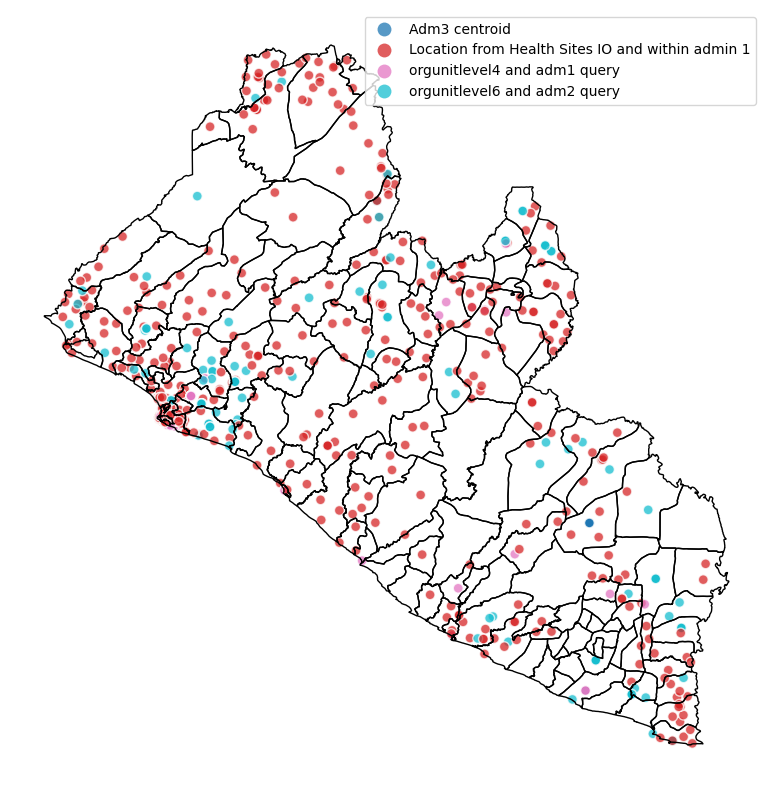

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
smallest_geob.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [48]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [49]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [50]:
len(records_subset)

1

In [51]:
for gIdx in range(len(geob_arr)-1, -1, -1):
    gNum = gIdx +1
    print(gIdx)

    geob = geob_arr[gIdx]
    results2 = gpd.sjoin(results2, geob[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
    results2.drop('index_right', axis=1, inplace=True)
    results2.rename(
        columns={
            'shapeName': f'geob_adm{gNum}',
            'shapeID': f'geob_adm{gNum}_id',
        }, inplace=True)

1
0


In [52]:
for gIdx in range(len(geob_arr)-1, -1, -1):
    gNum = gIdx +1
    print(results2[f"geob_adm{gNum}"].isna().sum())
    results2.rename(
        columns={
            f'adm{gNum}': f'fuzzy_match_adm{gNum}'
        }, inplace=True)

0
0


In [57]:
results_final = results2.copy()

In [59]:
ts = datetime.now().strftime("%m.%d.%y")
results_final.to_csv(join(output_dir, f"{iso3}_geocoding_{ts}.csv"))
results_final.to_file(join(output_dir, f"{iso3}_geocoding_{ts}.json"), driver="GeoJSON")